In [8]:
import numpy as np
import pandas as pd

#visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 20})
%matplotlib inline

#machine learn algrothism 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale 

#for statistics
from scipy import stats

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize data
The source of this data is a database at uci. This data was produced Kam Hamidieh at the University of Pennsyivania. This has no missing values and does not have to be wrangled outside of standardization.

The attributes of this database are the property elements that superconductor are composed of. Other than the critical point, none of the attributes are of the superconductor itself. The elemential properties are the atomic mass, first ionization energy, atomic radius, density, electron affinity, fusion heat, thermal conductivity, bond valence. Each of these attributes were seperated into the statistical features the mean of the elements, a weighted mean, a geometric mean, a wieghted geometric mean, entropy, weighted entropy, a range, weighted range, standard deviation weighted standard deviation. Weighted value considers of the ratio of elements while the unweighted does not. For more details see the link for the paper.There are 80 attributes (8 elemential properites X 10 tatistical features)

Source of data: http://archive.ics.uci.edu/ml/datasets/Superconductivty+Data
Source of paper:https://arxiv.org/abs/1803.10260
Access: Febuary 5, 20or19

In [9]:
#atom list
file = 'unique_m.csv'
atoms_pd = pd.read_csv(file)


#create list of the materials
material=atoms_pd['material']
#atoms_pd.set_index(keys=[material])
atoms_pd.drop(['material'],axis=1,inplace=True)

#delete elements of atoms_pd that do not appear in
dropped_column = []
for key, value in (atoms_pd.sum()==0).iteritems():
    if value:
        atoms_pd.drop([key],axis=1,inplace=True)
        dropped_column.append(key)
        

#properties list
file = 'train.csv'
prop_pd = pd.read_csv(file)

#create a dataframe with only the weighted average atomic mass
col_list= []
start_words = 'wtd_mean'
for col in prop_pd.columns:
    if start_words in col:
        col_list.append(prop_pd[col])
mean_only_df = pd.concat(col_list,axis=1)


# Appearance of element in superconductors

The figure below shows the number of superconductors for all elements present. The most abundant elements found in superconductor are oxygen, and copper appearing in 56.27% and 50.97% of superconductor in data set respectively.  There are 77 elements are present in superconductors database and 60 of them are present 5% of the time. With a high number but not overwhelming  of superconductors containing oxygen and copper, they may be some use in including it their presents in predictive model. In addition, 41.18% of superconductors do not contain oxygen or copper so including additional elements may be useful. Since properties used by Kam Hamidieh were derived from the elements present rather than the superconductors themselves, the properties are a proxy for the elements. It would be interesting to examine the performance of model from the elements present rather than the properties.  


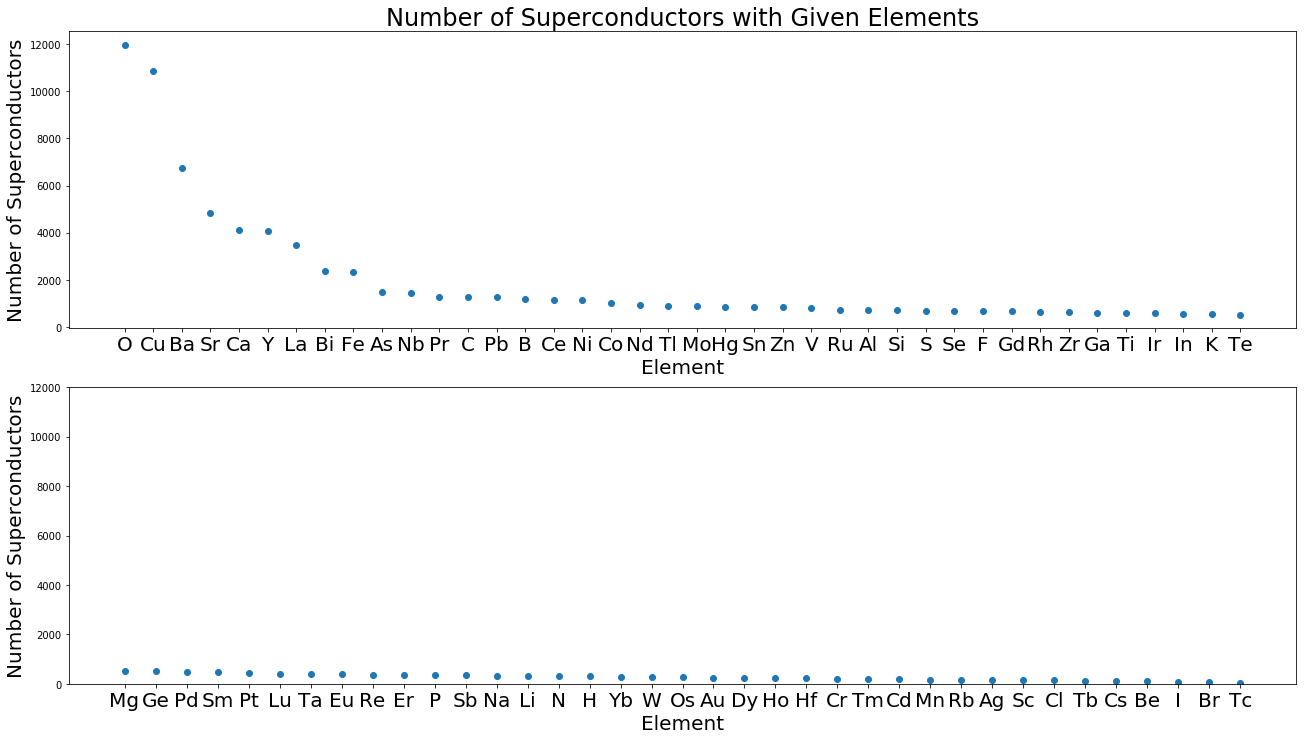

In [18]:
#number of elements with given elements
atoms_no_temp = atoms_pd.drop(['critical_temp'],axis=1)
element_count = atoms_no_temp.applymap(lambda x:0 if x==0 else 1).sum().sort_values(ascending=False)
element_percent = (element_count/atoms_pd.shape[0]*100).sort_values(ascending=False)

#number of superconductors with each element
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(2,1,1)
#plt.xlim(-1,77)
ax1.scatter(x=element_count.keys()[:40],y=element_count.values[:40])

ax1.set_title('Number of Superconductors with Given Elements',fontsize=24)
ax1.set_ylabel('Number of Superconductors',fontsize=20)
plt.yticks([0,2000,4000,6000,8000,10000,12000])
plt.xticks(fontsize=20)
plt.xlabel('Element',fontsize=20)
ax2 = fig.add_subplot(2,1,2)
ax2.scatter(x=element_count.keys()[40:],y=element_count.values[40:])
plt.yticks([0,2000,4000,6000,8000,10000,12000])
plt.xticks(fontsize=20)
ax2.set_ylabel('Number of Superconductors',fontsize=20)
plt.xlabel('Element',fontsize=20)
plt.savefig('Element_Analysis.jpg',bbox_inches='tight')
plt.show()


#percent of superconductors with each element
#plt.figure(figsize=(25,4))
#plt.scatter(x=element_percent.keys()[:40],y=element_percent.values[:40])
#plt.title('Percent of Superconductors with Elements',fontsize=20)
#plt.ylabel('Percentage of superconductors',fontsize=20)
#plt.xlabel('Element',fontsize=20)
#plt.show()

In [71]:
print('percent of elements that contain neither Cu or O is {:.2f}%.'.format(
    (~((material.str.contains('O')) |(material.str.contains('Cu')))).sum()/len(material)*100))
print('percent of elements that contain neither Cu, O or Ba is {:.2f}%.'.format(
    (~((material.str.contains('O')) |(material.str.contains('Cu'))|(material.str.contains('Ba')))).sum()/len(material)*100))

percent of elements that contain neither Cu or O is 41.18%.
percent of elements that contain neither Cu, O or Ba is 38.82%.


In [45]:
element_table = pd.concat([element_percent,element_count],axis=1)
element_table.columns = ['Percent','Number']
element_table['Percent'] = element_table['Percent'].apply(lambda x: str(round(x,2))+'%')
element_table.head(10)

,Percent,Number
O,56.27%,11964
Cu,50.97%,10838
Ba,31.75%,6751
Sr,22.82%,4852
Ca,19.34%,4112
Y,19.16%,4075
La,16.29%,3463
Bi,11.24%,2389
Fe,11.0%,2339
As,7.06%,1502


# Visualize distribute of properties
The figures below shows histagrams overlapping kde distribution for the features and the critical temperature. While there are 80 features, many of the features are different statistical values of the same properties. In order to reduce the number of feature shown to a reasonable amount, only the weight means are displayed.  For many of the properties, there are two peaks, a large one and a smaller. This is particularly important observation for the critical temperature since it is the only property that belongs to the superconductor itself rather than the element components. Other properties to see this double peak pattern are first ionization energy, atomic radius, and density. 

This double peak pattern may suggest that there are two separate populations of superconductors within the dataset. It is well known there are two types of superconductors, type I and type II. There are a few attributes that distinguish type I and type II such as their interaction with a magnetic field but more importantly for this project is their critical temperature. Type I superconductors have lower critical points. It is reasonable to assume that the exists of two peaks is a result of data set containing two types of superconductors.


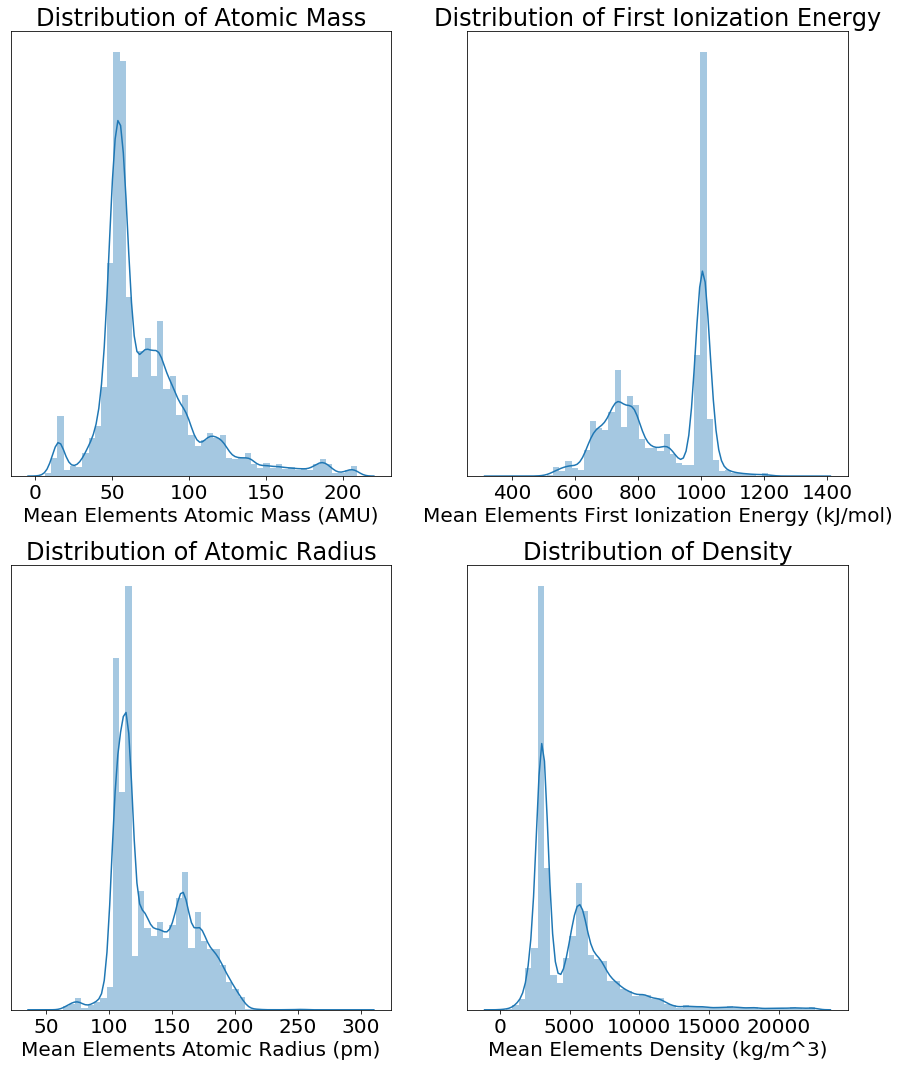

In [48]:
fig = plt.figure(figsize=(15,18)) 

#atomic mass
ax1 = fig.add_subplot(2,2,1)
sns.distplot(mean_only_df['wtd_mean_atomic_mass'],ax=ax1,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
ax1.set_title('Distribution of Atomic Mass',fontsize=24)
ax1.set_xlabel('Mean Elements Atomic Mass (AMU)',fontsize=20)

#First ionization energy
ax2 = fig.add_subplot(2,2,2)
sns.distplot(mean_only_df['wtd_mean_fie'],ax=ax2,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of First Ionization Energy',fontsize=24)
plt.xlabel('Mean Elements First Ionization Energy (kJ/mol)',fontsize=20)

#Atomic radius
ax3 = fig.add_subplot(2,2,3)
sns.distplot(mean_only_df['wtd_mean_atomic_radius'],ax=ax3,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Atomic Radius',fontsize=24)
plt.xlabel('Mean Elements Atomic Radius (pm)',fontsize=20)

#Density
ax4 = fig.add_subplot(2,2,4)
sns.distplot(mean_only_df['wtd_mean_Density'],ax=ax4,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Density',fontsize=24)
plt.xlabel('Mean Elements Density (kg/m^3)',fontsize=20)

plt.savefig('Supercon_hist1.jpg',bbox_inches='tight')
plt.show()



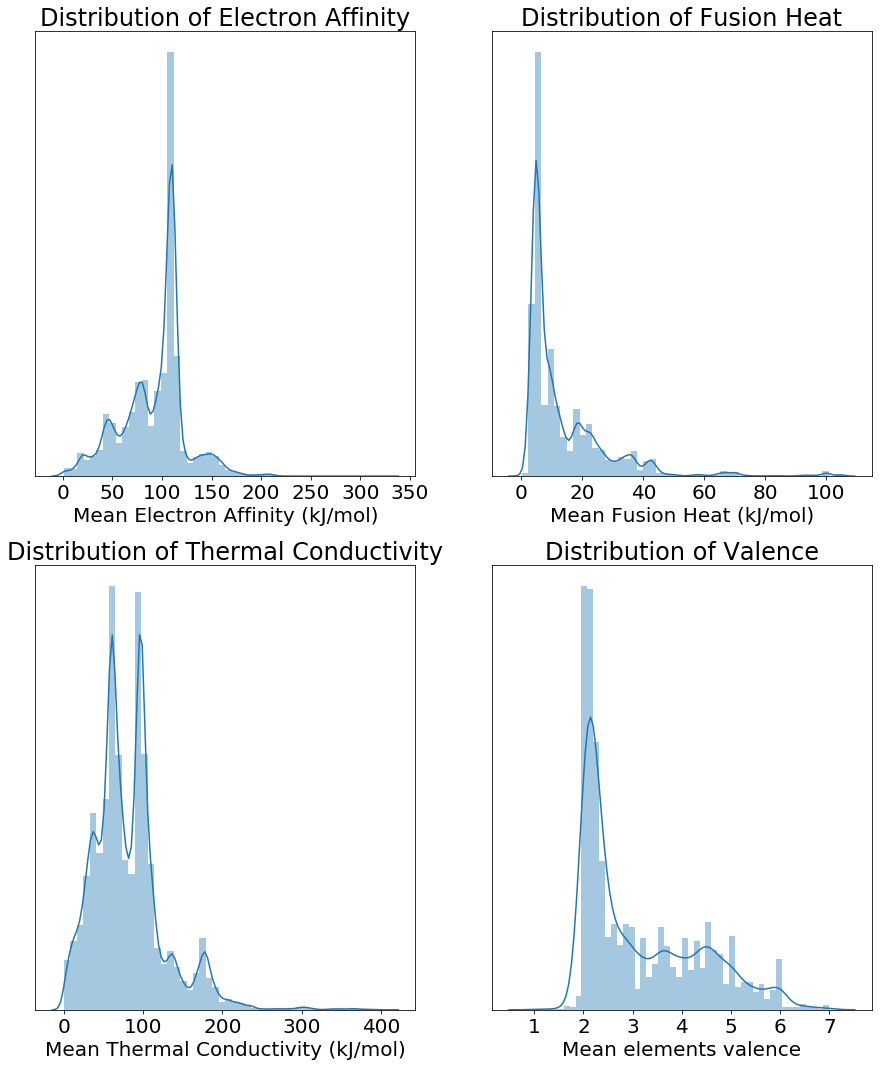

In [51]:
fig = plt.figure(figsize=(15,18)) 

#Electron Affinity
ax1 = fig.add_subplot(2,2,1)
sns.distplot(mean_only_df['wtd_mean_ElectronAffinity'],ax=ax1,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Electron Affinity',fontsize=24)
plt.xlabel('Mean Electron Affinity (kJ/mol)',fontsize=20)

#Electron Affinity
ax2 = fig.add_subplot(2,2,2)
sns.distplot(mean_only_df['wtd_mean_FusionHeat'],ax=ax2,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Fusion Heat',fontsize=24)
plt.xlabel('Mean Fusion Heat (kJ/mol)',fontsize=20)

#Thermal Conductivity
ax3 = fig.add_subplot(2,2,3)
sns.distplot(mean_only_df['wtd_mean_ThermalConductivity'],ax=ax3,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Thermal Conductivity',fontsize=24)
plt.xlabel('Mean Thermal Conductivity (kJ/mol)',fontsize=20)

#Valence
ax4 = fig.add_subplot(2,2,4)
sns.distplot(mean_only_df['wtd_mean_Valence'],ax=ax4,bins=50)
plt.yticks([])
plt.xticks(fontsize=20)
plt.title('Distribution of Valence',fontsize=24)
plt.xlabel('Mean elements valence',fontsize=20)

plt.savefig('Supercon_hist2.jpg',bbox_inches='tight')

plt.show()

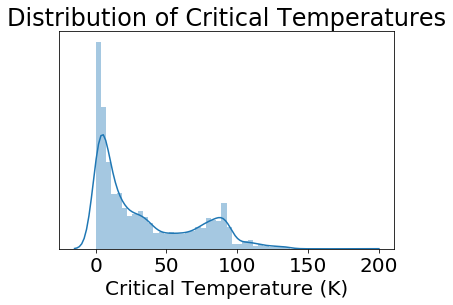

In [54]:
#critical temperature
ax4 = fig.add_subplot(2,2,4)
sns.distplot(prop_pd['critical_temp'],bins=50)
plt.yticks([])
plt.title('Distribution of Critical Temperatures',fontsize=24)
plt.xlabel('Critical Temperature (K)',fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('Supercon_hist3.jpg',bbox_inches='tight')

plt.show()


# Statistics Relations

Examine the staticals between attributes and critical temperature

In [111]:
def ScatterAndLinePlot(df,x_values,y_values,axis,x_label,y_label,x_units='',y_units=''):
    
    #scatter plot
    axis.scatter(df[x_values],df[y_values],color='blue')
    text= y_label +' vs ' + x_label 
    axis.set_title(text,fontsize=24) 
    if x_units != '':
        text = x_label + ' (' + x_units + ')' 
    else:
        text = x_label
    axis.set_xlabel(text,fontsize=20)
    if y_units != '':
        text = y_label + ' (' + y_units + ')' 
    else:
        text = x_label
    axis.set_ylabel(text,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    #linear regression
    lm = LinearRegression()
    x = df[[x_values]]
    y = df[y_values]
    lm.fit(x,y)
    intercept = float(lm.intercept_)
    slope = float(lm.coef_)
    x_low =  df[x_values].min()
    x_high = df[x_values].max()
    x_increments = (x_high-x_low)/10
    x_fit = np.arange(x_low,x_high,x_increments)
    y_fit = slope*x_fit+intercept
    axis.plot(x_fit,y_fit,color='red')
    text= 'line:' + format(slope,'.2e') + 'x+'+ format(intercept,'.2f') 
    
    #show Pearson Correlation and p value
    box_x = (x_high)/3
    box_y = (df[y_values].max())/3
    
    pearson,pvalue=stats.pearsonr(df[x_values],df[y_values])
    text += '\nr=' + format(pearson,'.3f') + '; p=' + format(pvalue,'.4f')
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
    axis.text(s=text,x=box_x,y=box_y,color='red',bbox=bbox_props,fontsize=20,horizontalalignment='left')


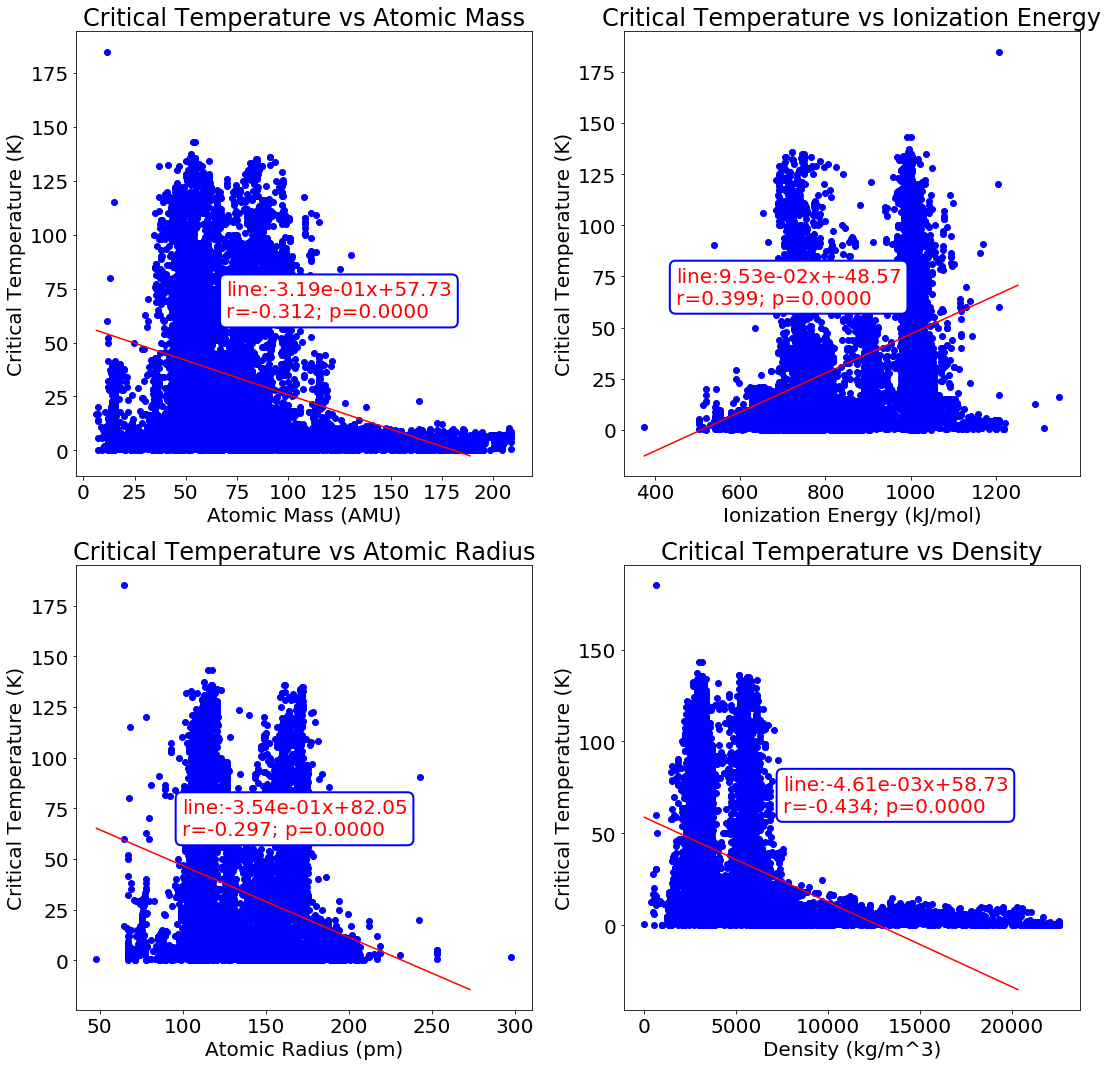

In [112]:
fig = plt.figure(figsize=(18,18)) 

#weighted mean atomic mass vs critical temperature
ax1 = fig.add_subplot(2,2,1)
ScatterAndLinePlot(prop_pd,'wtd_mean_atomic_mass','critical_temp',ax1
                   ,'Atomic Mass','Critical Temperature','AMU','K')
#weighted mean first ionization energy vs critical temperature
ax2 = fig.add_subplot(2,2,2)
ScatterAndLinePlot(prop_pd,'wtd_mean_fie','critical_temp',ax2
                   ,'Ionization Energy','Critical Temperature','kJ/mol','K')

ax3 = fig.add_subplot(2,2,3)
ScatterAndLinePlot(prop_pd,'wtd_mean_atomic_radius','critical_temp',ax3,
                   'Atomic Radius','Critical Temperature','pm','K')


ax4 = fig.add_subplot(2,2,4)
ScatterAndLinePlot(prop_pd,'wtd_mean_Density','critical_temp',ax4,
                   'Density','Critical Temperature','kg/m^3','K')

plt.savefig('Supercon_scatter1.jpg',bbox_inches='tight')

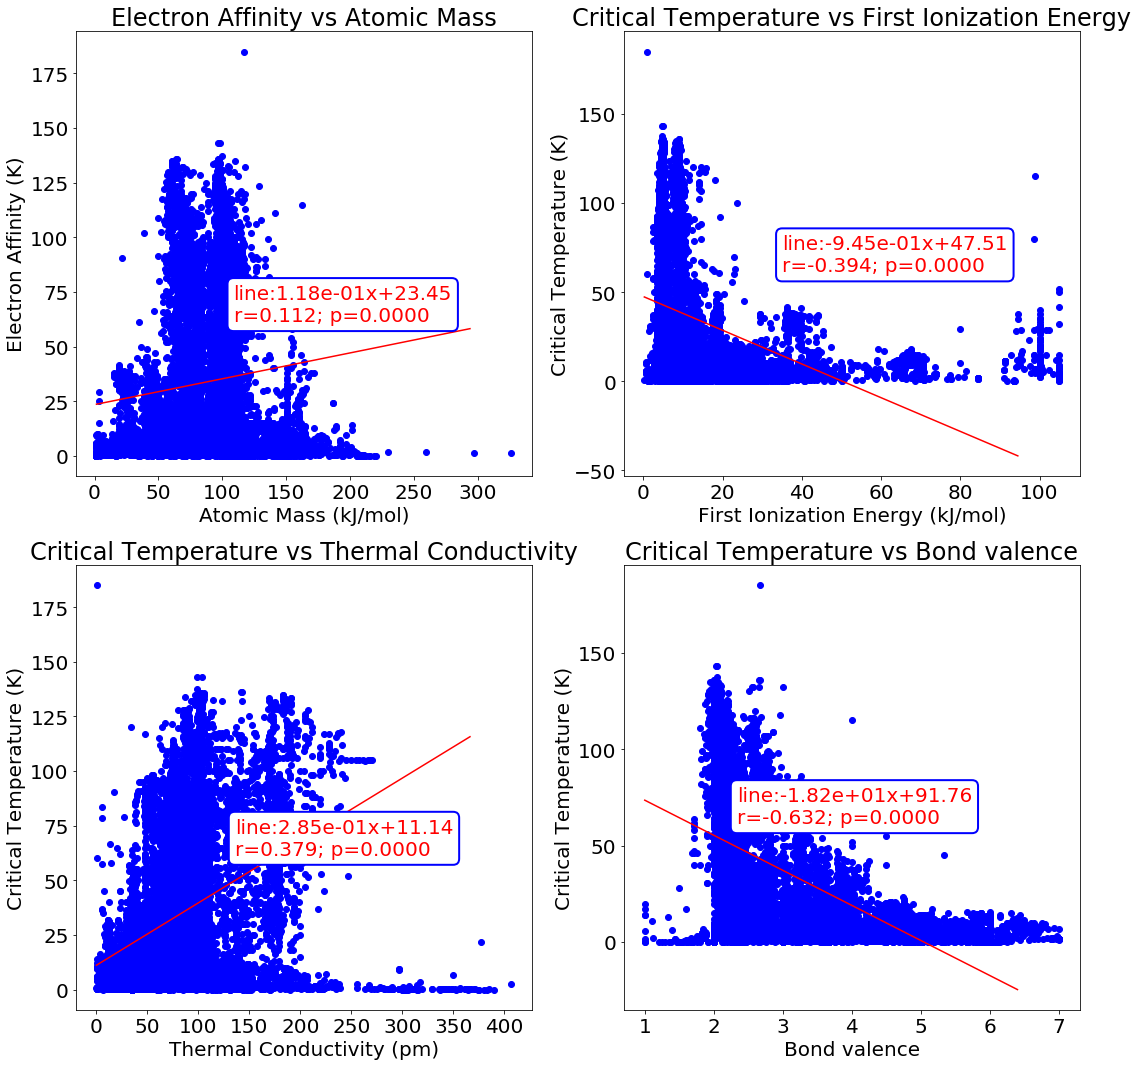

In [113]:
fig = plt.figure(figsize=(18,18)) 
#weighted mean atomic mass vs critical temperature
ax1 = fig.add_subplot(2,2,1)
ScatterAndLinePlot(prop_pd,'wtd_mean_ElectronAffinity','critical_temp',ax1
                   ,'Atomic Mass','Electron Affinity','kJ/mol','K')
#weighted mean first ionization energy vs critical temperature
ax2 = fig.add_subplot(2,2,2)
ScatterAndLinePlot(prop_pd,'wtd_mean_FusionHeat','critical_temp',ax2
                   ,'First Ionization Energy','Critical Temperature','kJ/mol','K')

ax3 = fig.add_subplot(2,2,3)
ScatterAndLinePlot(prop_pd,'wtd_mean_ThermalConductivity','critical_temp',ax3,
                   'Thermal Conductivity','Critical Temperature','pm','K')


ax4 = fig.add_subplot(2,2,4)
ScatterAndLinePlot(prop_pd,'wtd_mean_Valence','critical_temp',ax4,
                   'Bond valence','Critical Temperature','','K')

plt.savefig('Supercon_scatter2.jpg',bbox_inches='tight')